In [18]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

In [19]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

class GumHelper:
    def __init__(self, env, figsize=(3, 3)):
        self.env = env  # 初始化Gym环境
        self.figsize = figsize  # 初始化绘图窗口大小
        
        plt.figure(figsize=figsize) # 创建绘图窗口
        plt.title(self.env.spec.id if hasattr(env.spec, 'id') else '')  # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title=None):
        image_data = self.env.render()  # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data)   # 更新绘图窗口中的图像数据
        display.display(plt.gcf())  # 刷新显示
        display.clear_output(wait=True) # 有新图片时再清除绘图窗口原有图像
        if title:   # 如果有标题就显示标题
            plt.title(title)

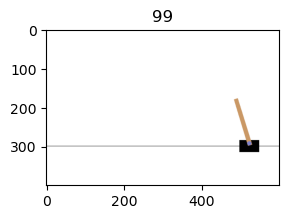

In [20]:
# 环境测试
env = gym.make('CartPole-v1', render_mode='rgb_array')
env.reset()
gym_helper = GumHelper(env)

for i in range(100):
    gym_helper.render(title=str(i))
    action = env.action_space.sample()
    env.step(action)

env.close()

In [21]:
import gym
from gym import spaces
import numpy as np
import random

class SnakeEnv(gym.Env):
    # 构造函数，参数为grid_size
    def __init__(self, grid_size=16):
        super(SnakeEnv, self).__init__()
        
        # 保存网格大小
        self.grid_size = grid_size
        # 蛇的初始位置，设为中心点
        self.snake = [(self.grid_size//2, self.grid_size // 2)]
        
        # 定义动作空间，上下左右
        self.action_space = spaces.Discrete(4)
        # 定义观测空间，是一个grid*grid*3的三维空间，值域为0到1
        self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size, grid_size), dtype=np.uint8)
        
        # 初始化食物变量
        self.food = None
        # 蛇行动总步数
        self.steps = 0
        # 蛇未吃到食物的步数，理解为饥饿度
        self.hungry = 0
        # 上一步的动作，初始化一个特殊值
        self.last_action = 10
        # 场上的食物数量
        self.num_food = 10
        # 游戏最大步数
        self.max_steps = 200
    
    # 环境重置函数
    def reset(self):
        # 蛇回到初始位置
        self.snake = [(self.grid_size//2, self.grid_size // 2)]
        # 食物重新生成
        self.food = self._generate_food()
        # 步数和饥饿度
        self.steps = 0
        self.hungry = 0
        # 返回当前状态和一个dict，对齐gym环境中的reset返回值
        return self._get_state(), {}
    
    # 动作执行函数
    def step(self, action):
        # 确定蛇头位置
        head = self.snake[0]
        
        # 如果蛇试图做和上一步相反的动作，那么保持上一步的动作不变
        if abs(action - self.last_action) == 2:
            action = self.last_action
        
        # 根据动作决定蛇头的新位置
        if action == 0:     # 上
            new_head = (head[0]-1, head[1])
        elif action == 1:   # 右
            new_head = (head[0], head[1]+1)
        elif action == 0:   # 下
            new_head = (head[0]+1, head[1])
        else:               # 左
            new_head = (head[0], head[1]-1)
        
        # 记录这一步的动作 步数+1
        self.last_action = action
        self.steps += 1
        
        # 如果蛇头的新位置在蛇身上，游戏结束，返回-100的奖励
        if new_head in self.snake:
            return self._get_state(), -100, True, self.steps >= self.max_steps, {}
        
        # 如果蛇头的位置超出界限，游戏结束，返回-200的奖励
        if self._is_out_of_bounds(new_head):
            return self._get_state(), -200, True, self.steps >= self.max_steps, {}
        
        # 如果新蛇头的位置有食物
        elif new_head in self.food:
            # 在蛇体数组的最前面插入一节蛇头的新位置
            self.snake.insert(0, new_head)
            # 重新生成食物
            self.food = self._generate_food()
            # 饥饿度归零
            self.hungry = 0
            # 游戏继续，返回50的奖励
            return self._get_state(), 50, False, self.steps >= self.max_steps, {}
        
        # 如果没有碰到蛇身或边界
        else:
            # 在蛇体数组的最前面插入一节蛇头的新位置
            self.snake.insert(0, new_head)
            # 去掉蛇最后一节
            self.snake.pop()
        
            # 默认奖励为0，饥饿度增加，如果饥饿度达到20，每一步给与一个负奖励
            r = 0
            self.hungry += 1
            if self.hungry >= 20:
                r -= (1 + (self.hungry - 20) / 100)
            
            return self._get_state(), r, False, self.steps >= self.max_steps, {}
    
    # 在动作空间随机选择一个动作
    def sample(self):
        return self.action_space.sample()
    
    # 渲染游戏界面，返回图像数组
    def render(self, mode='rgb_array'):
        # 初始化画布
        img = np.zeros((self.grid_size, self.grid_size, 3))
    
        # 绘制蛇体，蛇头是红色，蛇身是蓝色
        for i, s in enumerate(self.snake):
            if i == 0:
                img[s] = [1, 0, 0]  # 红色表示蛇头
            else:
                img[s] = [0, 0, 1]  # 蓝色表示蛇身
    
        # 食物设为绿色
        for f in self.food:
            img[f] = [0, 1, 0]  # 绿色表示食物
    
        # 返回图像
        return img
    
    # state直接就是图像数组
    def _get_state(self):
        return self.render()
    
    # 判断某个位置是否出界
    def _is_out_of_bounds(self, position):
        x, y = position
        return x < 0 or y < 0 or x >= self.grid_size or y >= self.grid_size

    # 生成食物
    def _generate_food(self):
        foods = []
        while True:
            # 每次生成一个食物
            food = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            # 食物不能在蛇身上，也不能在已有的食物上
            if food not in self.snake and food not in foods:
                foods.append(food)
            # 生成数量足够的食物则返回
            if len(foods) >= self.num_food:
                return foods

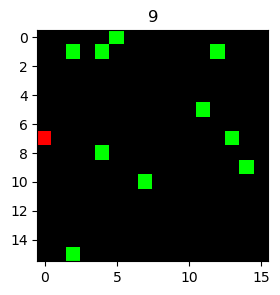

In [22]:
# 环境测试
env = SnakeEnv()
env.reset()
gym_helper = GumHelper(env)

for i in range(100):
    gym_helper.render(title=str(i))
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break

env.close()

In [24]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import *  # 用于显示进度条

# 策略模型，给定状态生成各个动作的概率
class PolicyModel(nn.Module):
    def __init__(self, grid_size, output_dim):
        super(PolicyModel, self).__init__()
        self.grid_size = grid_size

        # 定义卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=1),  # 使用1x1卷积升维
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=1),  # 使用1x1卷积降维
            nn.BatchNorm2d(4),
            nn.ReLU()
        )

        # 使用全连接层构建一个简单的神经网络。ReLU作为激活函数
        # 最后用一个Softmax层，使得输出可以看作是概率分布
        self.fc = nn.Sequential(
            nn.Flatten(),  # 将特征图展平成一维向量
            nn.Linear(grid_size * grid_size * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Softmax(dim=1)
        )
        
    # 定义前向传播，输出动作概率分布
    def forward(self, x):
        x = x.view(-1, 3, self.grid_size, self.grid_size)
        x = self.conv(x)
        action_prob = self.fc(x)
        return action_prob

# 价值模型，给定状态评估其价值
class ValueModel(nn.Module):
    def __init__(self, grid_size):
        super(ValueModel, self).__init__()
        self.grid_size = grid_size

        # 定义卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=1),  # 使用1x1卷积升维
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=1),  # 使用1x1卷积降维
            nn.BatchNorm2d(4),
            nn.ReLU()
        )

        # 构造简单的全连接层网络，输出维度为动作空间的维度
        self.fc = nn.Sequential(
            nn.Flatten(),  # 将特征展平为一维向量
            nn.Linear(grid_size * grid_size * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # 最终输出是一个标量，表示状态的价值
        )
    
    # 定义前向传播，输出价值估计
    def forward(self, x):
        x = x.view(-1, 3, self.grid_size, self.grid_size)
        x = self.conv(x)
        value = self.fc(x)
        return value


In [27]:
# 定义PPO类
class PPO:
    # 构造函数，参数包含环境，学习率，折扣因子，优势计算参数，clip参数，训练轮数
    def __init__(self, env, learning_rate=0.00002, gamma=0.99, lamda=0.95, clip_eps=0.1, epochs=10):
        self.env = env
        self.gamma = gamma
        self.lamda = lamda
        self.clip_eps = clip_eps
        self.epochs = epochs

        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # 根据环境的观测空间和动作空间，定义策略模型和价值模型，并将模型移动到指定设备上
        self.policy_model = PolicyModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.value_model = ValueModel(env.observation_space.shape[0]).to(self.device)

        # 定义Adam优化器
        self.policy_optimizer = torch.optim.Adam(self.policy_model.parameters(), lr=learning_rate)
        self.value_optimizer = torch.optim.Adam(self.value_model.parameters(), lr=learning_rate)

    # 使用策略模型生成动作概率分布并采样动作
    def choose_action(self, state):
        # 将状态转换为Tensor输入模型
        state = torch.FloatTensor(np.array([state])).to(self.device)
        with torch.no_grad():
            action_prob = self.policy_model(state)
    
        # 生成分布后采样返回动作
        c = torch.distributions.Categorical(action_prob)
        action = c.sample()
        return action.item()
    
    # 计算优势估计
    def calc_advantage(self, td_delta):
        # 将TD误差转换为numpy数组
        td_delta = td_delta.cpu().detach().numpy()
        
        # 初始化优势值和优势估计的列表
        advantage = 0
        advantage_list = []
        
        # 反向遍历，从最后一步开始推
        for r in td_delta[::-1]:
            # 将当前的TD误差和下一步的优势加权值作为当前步的优势
            advantage = r + self.gamma * self.lamda * advantage
            # 将当前的优势值插入到列表的最前端
            advantage_list.insert(0, advantage)
        
        # 转换为Tensor后返回
        return torch.FloatTensor(np.array(advantage_list)).to(self.device)
    
    # 模型更新
    def update(self, buffer):
        # 取出数据，并将其转换为numpy数组
        # 然后进一步转换为Tensor，并将数据移动到指定计算资源设备上
        states, actions, rewards, next_states, dones = zip(*buffer)
        
        states = torch.FloatTensor(np.array(states)).to(self.device)
        # actions = torch.tensor(np.array(actions)).view(-1, 1).to(self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).view(-1, 1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).view(-1, 1).to(self.device)
    
        with torch.no_grad():
            # 计算旧策略下的动作概率
            old_action_prob = torch.log(self.policy_model(states).gather(1, actions))
            
            # 计算TD目标
            td_target = rewards + (1 - dones) * self.gamma * self.value_model(next_states)
            td_delta = td_target - self.value_model(states)
    
        # 优势估计
        advantage = self.calc_advantage(td_delta)
    
        # 多步更新策略
        for i in range(self.epochs):
            # 计算新的动作概率
            action_prob = torch.log(self.policy_model(states).gather(1, actions))
            # 计算策略的相对变化率
            ratio = torch.exp(action_prob - old_action_prob)
            
            # CLIP损失
            part1 = ratio * advantage
            part2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantage
            # 计算策略损失
            policy_loss = -torch.min(part1, part2).mean()
    
            # 计算价值损失
            value_loss = F.mse_loss(self.value_model(states), td_target).mean()
    
            # 优化过程，反向传播，更新参数
            self.policy_optimizer.zero_grad()
            self.value_optimizer.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            self.policy_optimizer.step()
            self.value_optimizer.step()



In [28]:
# 定义超参数
max_episodes = 10000  # 训练episode数
max_steps = 200  # 每个回合的最大步数

# 创建PPO对象
agent = PPO(env)
# 定义保存每个回合奖励的列表
episode_rewards = []

# 开始训练，tqdm用于显示进度条并评估任务时间开销
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state, _ = env.reset()
    # 当前回合的奖励
    episode_reward = 0
    # 记录每个episode的信息
    buffer = []

    # 循环进行每一步操作
    for step in range(max_steps):
        # 根据当前状态选择动作
        action = agent.choose_action(state)
        # 执行动作，获取反馈信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated

        # 将这个五元组添加到buffer中
        buffer.append((state, action, reward, next_state, done))
        # 累计奖励
        episode_reward += reward

        # 更新当前状态
        state = next_state

        if done:
            break

    # 更新策略
    agent.update(buffer)
    # 记录当前回合奖励值
    episode_rewards.append(episode_reward)

    # 打印中间值
    if episode % (max_episodes // 10) == 0:
        tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))


Episode 0: -150                          
Episode 1000: -18.36                               
Episode 2000: -50                                   
Episode 3000: -61.55                                
Episode 4000: -324.40999999999997                   
Episode 5000: -519.06                               
Episode 6000: -50                                   
Episode 7000: -50                                   
Episode 8000: -228.0                                
Episode 9000: -50                                   
100%|██████████| 10000/10000 [20:07<00:00,  8.28it/s]


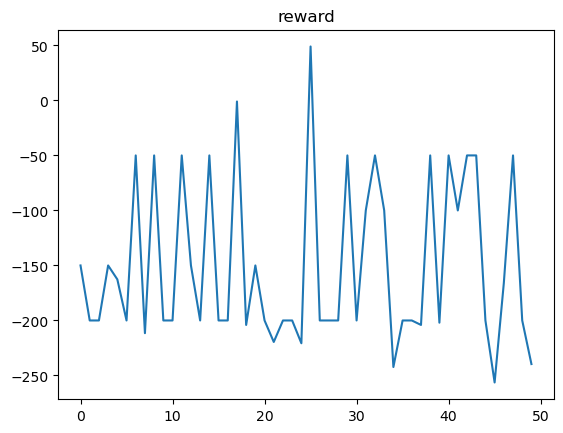

In [29]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(episode_rewards[:50])
plt.title("reward")
plt.show() 

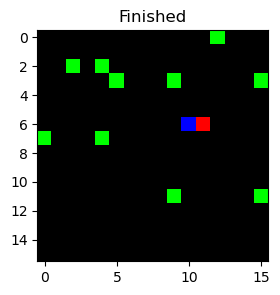

In [34]:
 # 重置环境，开始新的一个游戏回合
observation, _ = env.reset()

# 创建GymHelper对象来帮助图像显示
gym_helper = GumHelper(env, figsize=(3, 3))

# 开始游戏
for i in range(200):
    # 渲染环境，title为当前步数
    gym_helper.render(title=str(i))

    # 根据当前状态下的策略选择动作
    action = agent.choose_action(observation)
    
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)

    # 如果游戏结束，跳出当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title="Finished")

# 关闭环境
env.close()
